# PUC metagenomics

Let’s begin by importing the modules we’ll need.

In [21]:
import pandas as pd
import numpy as np

from mprod.dimensionality_reduction import TCAM
from mprod import table2tensor
from IPython.display import display_markdown

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
%matplotlib inline



Once pandas is loaded, we can read the dataset

## Dataset

The following example is adapted from this study [1]. They evaluated the role of the gut microbiome in disease course for 405 pediatric, new-onset, treatment-naive UC patients. Patients were monitored for 1 year upon treatment initiation, and microbial taxonomic composition was analyzed from fecal samples and rectal samples using 16S rRNA gene amplicon sequencing. In this example we will analyze the longitudinal stool samples and the association with two different factors:
 
1. Treatment
    * 5ASA: 5-aminosalicylic acid (5-ASA) compound, mesalamine
    * CS-Oral: corticosteroids (oral administration), followed by mesalamine
    * CS-IV: corticosteroids (intravenous administration), followed by mesalamine
2. Disease state
    * Flare
    * Remission
    
Fecal samples were collected at baseline (week 0, prior to treatment) and 3 follow-up time points (4, 12, and 52 weeks after treatment initiation).

In [48]:
file_path = "https://raw.githubusercontent.com/UriaMorP/tcam_analysis_notebooks/main/Schirmer2018/Schirmer2018.tsv"
data_raw = pd.read_csv(file_path, index_col=[0,1], sep="\t"
                       , dtype={'Week':int})

meta_path = "https://raw.githubusercontent.com/UriaMorP/tcam_analysis_notebooks/main/Schirmer2018/metadata_Schirmer2018.tsv"
meta = pd.read_csv(meta_path, index_col=[0], sep="\t")

display_markdown("Data table:", raw=True)
display(data_raw.head())
display_markdown("Inspection of row (sample) sums in the data", raw=True)
display(data_raw.sum(axis=1).head())

display(meta.head())

data_ra = data_raw.div(data_raw.sum(axis=1), axis=0) # make sure the data is of relative abundance

Data table:

k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Ruminococcaceae-g__Oscillospira-s__-OTU_310886  \
SubjectID Week                                                                                                               
P_10343   0                                              0.000000                                                            
          4                                              0.000183                                                            
          12                                             0.000000                                                            
          52                                             0.000000                                                            
P_10897   0                                              0.000423                                                            

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Peptostreptococcaceae-g__-s__-OTU_531374  \
SubjectID Week                                                                                                         
P_10343   0                                              0.000000                                                      
          4                                              0.000000                                                      
          12                                             0.000000                                                      
          52                                             0.000097                                                      
P_10897   0                                              0.000000                                                      

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__-g__-s__-OTU_366584  \
SubjectID Week                                                                                    
P_10343   0                                              0.000000                                 
          4                                              0.008966                                 
          12                                             0.000000                                 
          52                                             0.000000                                 
P_10897   0                                              0.000059                                 

                k__Bacteria-p__Proteobacteria-c__Betaproteobacteria-o__Burkholderiales-f__Alcaligenaceae-g__Sutterella-s__-OTU_173726  \
SubjectID Week                                                                                                                          
P_10343   0                                                   0.0                                                                       
          4                                                   0.0                                                                       
          12                                                  0.0                                                                       
          52                                                  0.0                                                                       
P_10897   0                                                   0.0                                                                       

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Ruminococcaceae-g__-s__-OTU_366794  \
SubjectID Week                                                                                                   
P_10343   0                                                   0.0                                                
          4                                                   0.0                                                
          12                                                  0.0                                                
          52                                                  0.0   

Inspection of row (sample) sums in the data

SubjectID  Week
P_10343    0       0.999989
           4       0.999576
           12      0.999382
           52      0.999243
P_10897    0       0.999476
dtype: float64

,Treatment,Remission
SubjectID,,
P_10343,5ASA,No remission
P_10897,CS-Oral,Remission
P_1108,CS-Oral,Remission
P_11085,5ASA,Remission
P_11369,CS-IV,Remission


## Preprocessing and baseline normalization

Since microbiome data tends to cluster by participant, meaning that variation coming from interindividual differences tend overshadow any other source of variation, including temporal trends, the task of identifying mutual temporal trajectories in microbiome composition is very challenging.<br>
Keeping in mind that we are only concerned with the direction of temporal variation trends (rather than the concrete baseline), one simple way of tackling this challenge would be to look at deviations from the baseline period.<br>
That is, instead of looking at raw values $x_{ij}$ (the $j^{th}$ time point of subject $i$), we consider tthe followoing:

$$
z_{ij} = \log_{2}(x_{ij} / \mu(x_{i}) )
$$

where $\mu ( x_{i} )$ denotes the mean of baseline measurements of subject $i$ . <br>
Using pandas, this transfromation looks like:

In [83]:
data = 100 * data_ra.copy()
print(data.shape)
cap_val = 1.5
data[data < cap_val] = cap_val
data = data.loc[:,data.max()> cap_val ] # remove "zero" features
print(data.shape)
data = data.div(data.sum(axis=1), axis=0)

data_normalized = data.groupby(level = 'SubjectID')\
                    .apply(lambda x:np.log2( x/x.query("Week == 0").mean() )) 

display(data_normalized.head())

(348, 1015)
(348, 288)


k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Ruminococcaceae-g__Oscillospira-s__-OTU_310886  \
SubjectID Week                                                                                                               
P_10343   0                                              0.000000                                                            
          4                                              0.041061                                                            
          12                                             0.018220                                                            
          52                                            -0.000216                                                            
P_10897   0                                              0.000000                                                            

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Peptostreptococcaceae-g__-s__-OTU_531374  \
SubjectID Week                                                                                                         
P_10343   0                                              0.000000                                                      
          4                                              0.041061                                                      
          12                                             0.018220                                                      
          52                                            -0.000216                                                      
P_10897   0                                              0.000000                                                      

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__-g__-s__-OTU_366584  \
SubjectID Week                                                                                    
P_10343   0                                              0.000000                                 
          4                                              0.041061                                 
          12                                             0.018220                                 
          52                                            -0.000216                                 
P_10897   0                                              0.000000                                 

                k__Bacteria-p__Proteobacteria-c__Betaproteobacteria-o__Burkholderiales-f__Alcaligenaceae-g__Sutterella-s__-OTU_173726  \
SubjectID Week                                                                                                                          
P_10343   0                                              0.000000                                                                       
          4                                              0.041061                                                                       
          12                                             0.018220                                                                       
          52                                            -0.000216                                                                       
P_10897   0                                              0.000000                                                                       

                k__Bacteria-p__Firmicutes-c__Clostridia-o__Clostridiales-f__Lachnospiraceae-g__-s__-OTU_975306  \
SubjectID Week                                                                                                   
P_10343   0                                              0.000000                                                
          4                                              0.486781                                                
          12                                             0.018220                                                
          52                                            -0.000216   

Note that we apply the division and log transformation only after "capping" 

## TCAM

We will start reshaping the pre-processed multi-indexed dataframe to form a tensor (87 subjects, 1015 features, and 4 reps), confirming the mapping of each mode1 (frontal) slice index of the tensor to the original subject name and the mapping of each mode3 (lateral) slice index of the tensor to the original rep id.

In [84]:
tensor_data, mode1_map, mode3_map = table2tensor(data_normalized)
mode1_reverse_map = {val:k for k,val in mode1_map.items()}

display(tensor_data.shape)
print(mode1_map)
print(mode3_map)

(87, 288, 4)

{'P_10343': 0, 'P_10897': 1, 'P_1108': 2, 'P_11085': 3, 'P_11369': 4, 'P_11516': 5, 'P_11668': 6, 'P_11783': 7, 'P_11833': 8, 'P_11983': 9, 'P_12052': 10, 'P_1224': 11, 'P_12293': 12, 'P_12425': 13, 'P_12532': 14, 'P_12674': 15, 'P_13000': 16, 'P_13045': 17, 'P_13233': 18, 'P_13380': 19, 'P_13450': 20, 'P_13459': 21, 'P_14053': 22, 'P_14195': 23, 'P_14381': 24, 'P_14392': 25, 'P_14401': 26, 'P_14486': 27, 'P_1450': 28, 'P_14523': 29, 'P_14696': 30, 'P_15058': 31, 'P_15102': 32, 'P_1568': 33, 'P_1616': 34, 'P_1689': 35, 'P_1739': 36, 'P_2171': 37, 'P_2198': 38, 'P_2548': 39, 'P_2667': 40, 'P_2682': 41, 'P_3159': 42, 'P_3185': 43, 'P_3906': 44, 'P_41': 45, 'P_4196': 46, 'P_4199': 47, 'P_4522': 48, 'P_4892': 49, 'P_5028': 50, 'P_5170': 51, 'P_5347': 52, 'P_5356': 53, 'P_5366': 54, 'P_5463': 55, 'P_5491': 56, 'P_588': 57, 'P_6160': 58, 'P_6259': 59, 'P_6333': 60, 'P_6424': 61, 'P_7011': 62, 'P_7218': 63, 'P_7426': 64, 'P_7505': 65, 'P_7694': 66, 'P_7805': 67, 'P_7899': 68, 'P_7939': 69, 'P

Let's get right to the heart of the method. Now, we will run the tensor dimensionality reduction algorithm. In particular, we will apply the TSVDM (truncated singular value decomposition method) based tensor component analysis. In this example, we will work with all components, explaining more than 99% of the variability.
Then, we will plot the values of two different principal components, coloring the patients based on the remission status.

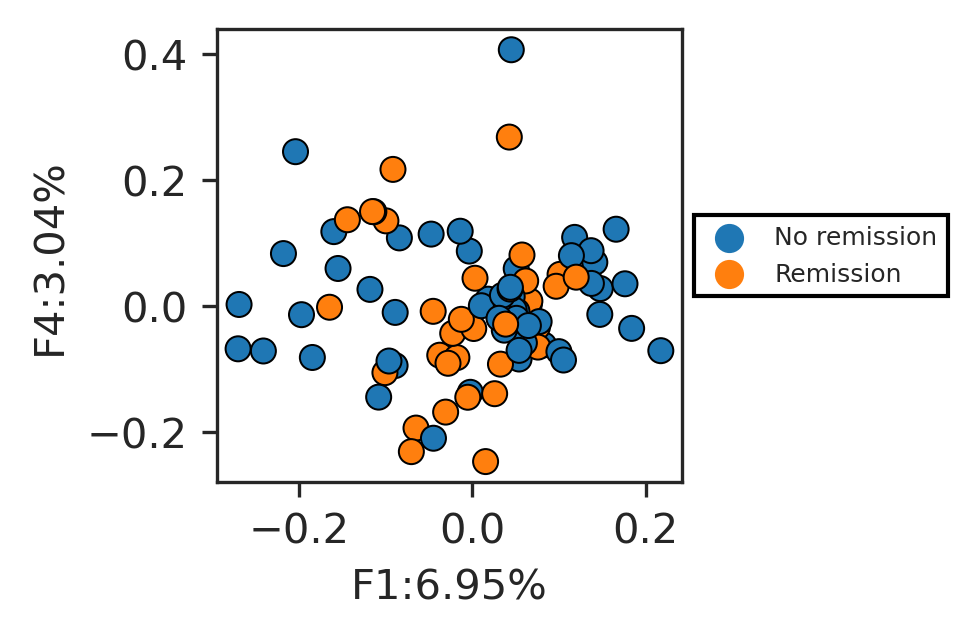

In [100]:
tcam = TCAM(n_components=None)    # will produce minimal number of components such that
                                # total explained var > 99%

transformed_data = tcam.fit_transform(tensor_data)

df_tca = pd.DataFrame(transformed_data).rename(index = mode1_reverse_map)


rounded_expvar = np.round(100*tcam.explained_variance_ratio_,2)

df_tca.columns = [f'F{i}:{val}%' for i,val in enumerate(rounded_expvar, start = 1)]

df_plot = meta.merge(df_tca, left_on = 'SubjectID', right_index=True)

f1 = df_tca.columns[0]
f2 = df_tca.columns[3]

fig, ax = plt.subplots(figsize = [2,2], dpi = 300)

sns.scatterplot(data = df_plot, x = f1, y = f2 , hue='Remission', ax = ax, edgecolor = 'k', linewidths=.1)

ax.legend(loc='center left', fontsize = 6, fancybox = False, framealpha = 1, edgecolor = 'k', bbox_to_anchor=(1, 0.5))

plt.show()

Similarly, we will plot the values of two principal components, showing no clear clustering, although a partial clustering can be observed in the patients treated with CS-IV (in this case coloring subjects based on the treatment), which means that the microbiome trajectory along the treatment is significantly differentt in those CS-IV patients

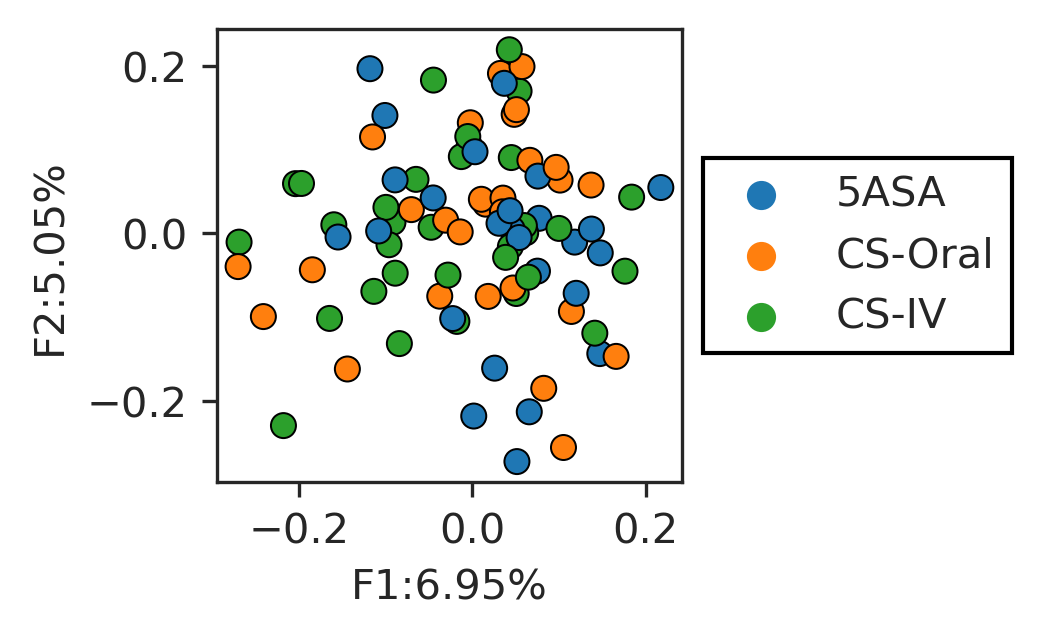

In [87]:
f1 = df_tca.columns[0]
f2 = df_tca.columns[1]

fig, ax = plt.subplots(figsize = [2,2], dpi = 300)

sns.scatterplot(data = df_plot, x = f1, y = f2 , hue='Treatment', ax = ax, edgecolor = 'k', linewidths=.1)

ax.legend(loc='center left', fancybox=False, framealpha = 1, edgecolor = 'k', bbox_to_anchor=(1, 0.5))
plt.show()

## References
<a id="1">[1]</a> 
Schirmer M. et al (2018). 
Compositional and Temporal Changes in the Gut Microbiome of Pediatric Ulcerative Colitis Patients Are Linked to Disease Course.
Cell Host & Microbe, Volume 24, Issue 4, Pages 472-474